# First Order Differential Model

Expands upon the simple set of features used in `n3060_std` by taking their frame-to-frame differential, the difference between the current frame and the most recent frame observed.

#### *Why include differences?*

The image and audio processes in the field are dependent on numerous factors (wind, time of day, weather)
and so the value of the features generated at any one time are not actuallystationary processes,
there are variations but the processes are the cumulative sum of these variations.
In time-series analysis, to deal with such processes one needs to apply a differential,
where by we use the rate of change of the features as inputs to the model.

To achieve this, the model needs to have not only the most recent frame available, but also
the previous frame. It then finds the difference between these and proceeds as with n3060_std in
feature extraction.

#### *Potential Deployment Issues*

The dataset that was generated here assumes that the model can operate at a constant 30 frames per second - so the difference observed is simply the difference in the underlying processes over 1/30th of a second. If the model when deployed is not able to obtain 30 frames per second then it is likely that the results will be different to those when training the model since the differences will occur over a longer time period.

A potential way to mitigate this in deployment is to scale the numerical difference by the time between frames. For example, if a the deployed frame-rate is only 15 frames per second then there is 1/15 second between frames and the feature values should therefore be halved.
Essentially we are assuming that:

$$\frac{\partial_{\text{process}}}{\partial_{\text{time}}} = c$$
for some constant c.

Numerically this is:
$$\frac{\Delta_{\text{process}}}{\Delta_{\text{time}}} = c$$
where we have $\Delta_{\text{time}}$ as the time between frames.

#### To Replicate Results:
Use `general_constructor.py` which is designed to generate data to be used for training models when given a certain dataset configuration (stored in the directory supplied for argument `-m`).

Can also specify where to save the output csv file with `-s`, database to draw labels from `-db` and total number of frames to generate `-n`.
```
python common/model/training/general_constructor.py \
-s "/home/matthew/Documents/GapWatch/common/model/training/n3060_dif/n3060_dif.csv" \
-m "common.model.training.n3060_dif.n3060_dif" \
-db "common/data/labels/app/frames.db" \
-n "4000"
```
The frames are sampled such that each class has an equal number of frames in the output dataset (regardless of the frequency of video clips stored in the label database .db file), which should allow for fairer inference. This behaviour can be changed by editing `general_constructor.py` and changing the `frame_target` array to the desired weighting.

The `general_constructor.py` file first builds an index of frames to search through, such that each class is equally represented in the data. If a class is less frequent in the labels data (as "Danger" was) then it samples more frames from the videos of that particular class.

Once the index of frames has been constructed:

* Open the .mp4 file in OpenCV and seek to the desired frame
* Perform resizing and feature extraction according to the database configuration
  * Eg. may need to include some previous frames to get the difference between them
  These transformations are generally run in parallel if Intel MKL is installed as quite often they will boil down to simple matrix operations
* Convert the .mp4 file to .wav format with ffmpeg (this is usually single threaded)
* Seek to the desired frames in the audio file output by ffmpeg and extract the features again as defined in the database configuration file
* Close the video and audio tracks and save this chunk to the csv file. Repeat for all labels stored in the .db file.

In [1]:
# load model and data and any imports
# imports and model specific settings
# perform imports
import numpy as np
import pandas as pd
from pathlib import Path

# standard libraries
import importlib, argparse, os.path, os, sys, time, sqlite3, subprocess, progressbar

# attempt to import the dataset configuration itself
# Add the git root directory to python path
# unfortunately need to do this manually because Jupyter
# sets the current working directory to the location of the notebook .ipynb file
git_root = "/home/matthew/Documents/GapWatch"
model_module = "common.model.training.n3060_dif.n3060_dif"
data_path = "common/model/training/n3060_dif/n3060_dif.csv"
sys.path.insert(0,git_root)

# custom helper scripts
import common.model.training.training_utils as tu

# import the model
m = importlib.import_module(model_module)

# read the data
df = pd.read_csv(os.path.join(git_root,data_path))

# headers should be the same as m.const_header()
# to keep headers consistent throughout the project
headers = df.columns.values
print("Dataframe Header: \n{}".format(headers))

Dataframe Header: 
['label' 'video_url' 'frame' 'mean' 'd_mean' 'var' 'd_var' 'kurt' 'd_kurt'
 'skew' 'd_skew' 'mfcc_0' 'mfcc_1' 'mfcc_2' 'mfcc_3' 'mfcc_4' 'mfcc_5'
 'mfcc_6' 'mfcc_7' 'mfcc_8' 'mfcc_9' 'd_mfcc_0' 'd_mfcc_1' 'd_mfcc_2'
 'd_mfcc_3' 'd_mfcc_4' 'd_mfcc_5' 'd_mfcc_6' 'd_mfcc_7' 'd_mfcc_8'
 'd_mfcc_9']


In [2]:
# select the X and y to be used for modeling
ml_df = df.copy() # make a copy
X_cols = headers[3:] # numeric features
y_cols = headers[0] # "label"

# NOTE: Perform standardisation inside the model pipeline
# as should not use test data for mean and standard deviation estimates!

# Models

Will consider the following models:

1. Logistic Regression
2. Decision Tree Classifier

## Train-Valid-Test Split
Split the frames by `video_url` as this will ensure that the unseen data doesn't contain frames from videos that the model has been exposed to. This is particularly important because some of the features are video dependent (eg. lighting, weather etc) and the model should not have seen any of those criteria if the frame is truly "unseen".

In [3]:
# get the video urls to determine unique videos
video_urls = ml_df.loc[:,headers[1]].unique()

# randomly sample
np.random.seed(0)
train_prop = 0.5 # save half the videos for validation run
val_prop   = 0.25
train_idx = np.random.choice(len(video_urls),int(np.floor(train_prop*len(video_urls))),
                           replace=False)
val_idx_full   = np.setdiff1d(np.arange(len(video_urls)), train_idx)

val_idx = np.random.choice(val_idx_full,int(np.floor(val_prop*len(video_urls))),
                           replace=False)
test_idx = np.setdiff1d(val_idx_full, val_idx)

# find the videos corresponding to these indices
train_videos = video_urls[train_idx]
val_videos   = video_urls[val_idx]
test_videos   = video_urls[test_idx]


ml_train = ml_df.loc[ml_df[headers[1]].isin(train_videos),:]
ml_val   = ml_df.loc[ml_df[headers[1]].isin(val_videos)  ,:]
ml_test  = ml_df.loc[ml_df[headers[1]].isin(test_videos) ,:]

print("Train set shape: ", ml_train.shape)
print("Validation set shape: ",ml_val.shape)
print("Test set shape: ",ml_test.shape)

Train set shape:  (2062, 31)
Validation set shape:  (1018, 31)
Test set shape:  (956, 31)


## Logistic Regression
### Training

In [4]:
# load scikit learn logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # (x-mu)/sigma

# hide convergence warnings
import warnings
warnings.filterwarnings("ignore")

# show progress
import progressbar

def score_model(clf, X_test, y_test, t=False):
    # get predictions
    if t:
        # user defined threshold
        y_score = clf.predict_proba(X_test)[:,1]
        y_hat = np.where(y_score > t, 1, 0)
    else:
        y_hat = clf.predict(X_test)
    # get the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    # get accuracy
    acc  = (tn+tp)/(tn+fp+fn+tp)
    # get sensitivity
    sens = tp/(tp+fn)
    # get specificity
    spec = tn/(tn+fp)
    return acc, sens, spec
    

# perform bootstrapping to observe which coefficients can be dropped
b = 200
n_train = 0.5 # train on half, test on half

# storage for accuracy, sensitivity, specificity (for both train and test to check for overfitting)
scores = np.zeros((b, 6))
bs = ShuffleSplit(n_splits = b,
                 random_state=0,
                 test_size=0.5)
conf = .9 # form a 90% confidence interval to include significant variables
X_cols_0 = X_cols.copy() # make a copy to prevent weirdness happening
stop_cond = False
while not stop_cond:
    # define the response and predictors
    X = ml_train[X_cols_0]
    y = np.where(ml_train[y_cols]=="Danger",1,0) # 1: Danger, 0 No_Danger
    # iterate training the model and performing variable selection
    params = np.zeros((b,1+len(X_cols_0))) # storage for coefficeints
    iter = 0
    with progressbar.ProgressBar(max_value=b) as bar:
        for train_index, test_index in bs.split(X):
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]
            # fit the classifier
            lr_pipe = Pipeline([('scaler', StandardScaler()),
                  ('lr', LogisticRegression(random_state=0,
                                           solver="sag"))])
            lr_pipe.fit(X_train, y_train)
            # Automatically tune the threshold to the training data
            y_hat = lr_pipe.predict_proba(X_train)[:, 1]
            p, r, thresholds = tu.precision_recall_curve(y_train, y_hat)
            target_r = 0.95
            t_opt = thresholds[np.argmin(np.abs(r-target_r))]
            
            # record the model parameters
            params[iter,:] = np.squeeze(np.hstack((lr_pipe.named_steps['lr'].intercept_[:,None],
                                                   lr_pipe.named_steps['lr'].coef_)))
            # score the model on train data first
            scores[iter,:3] = score_model(lr_pipe, X_train, y_train, t=t_opt)
            # score the model on test data
            scores[iter,3:] = score_model(lr_pipe, X_test, y_test, t=t_opt)
            # iteration counter
            bar.update(iter)
            iter +=1
    # check the parameters for ones that are not significantly different to zero and drop
    # then refit the model
    # We cannot drop the intercept!
    up = np.percentile(params[:,1:], 100*(1-(1-conf)/2), axis=0)
    down = np.percentile(params[:,1:], 100*(1-conf)/2, axis=0)
    keep = np.where((up>0)&(down<0),False, True)
    not_keep = np.where((up>0)&(down<0),True, False)
    X_cols_1 = X_cols_0[keep]
    print("Variables Kept:\n{}\n".format(X_cols_1))
    print("Variables Removed:\n{}\n".format(X_cols_0[not_keep]))
    # update the columns to use in the model
    X_cols_0 = X_cols_1
    if False in keep:
        stop_cond = False
    else:
        print("Stopping condition reached, no more variables to drop")
        stop_cond = True
        
    

100% (200 of 200) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
  1% (3 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:07

Variables Kept:
['mean' 'var' 'd_var' 'kurt' 'skew' 'mfcc_0' 'mfcc_1' 'mfcc_2' 'mfcc_7'
 'd_mfcc_0' 'd_mfcc_1' 'd_mfcc_3' 'd_mfcc_4' 'd_mfcc_7']

Variables Removed:
['d_mean' 'd_kurt' 'd_skew' 'mfcc_3' 'mfcc_4' 'mfcc_5' 'mfcc_6' 'mfcc_8'
 'mfcc_9' 'd_mfcc_2' 'd_mfcc_5' 'd_mfcc_6' 'd_mfcc_8' 'd_mfcc_9']



100% (200 of 200) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


Variables Kept:
['mean' 'var' 'd_var' 'kurt' 'skew' 'mfcc_0' 'mfcc_1' 'mfcc_2' 'mfcc_7'
 'd_mfcc_0' 'd_mfcc_1' 'd_mfcc_3' 'd_mfcc_4' 'd_mfcc_7']

Variables Removed:
[]

Stopping condition reached, no more variables to drop


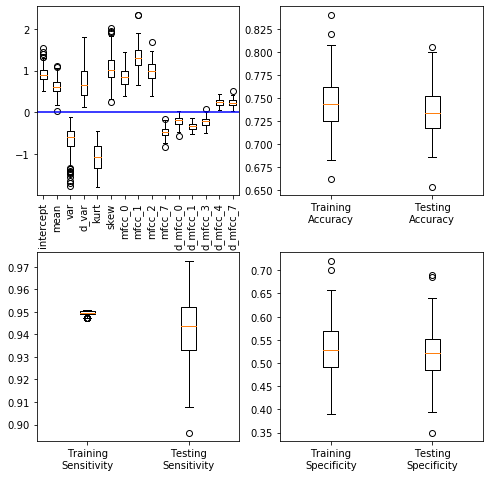

In [5]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# boxplot of the parameters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(2, 2, 1)
ax.boxplot(params)
ax.axhline(y=0, c="b")
x_ax_labs = np.insert(X_cols_0,0,"intercept") 
ax.set_xticklabels(x_ax_labs, rotation = 90)


# boxplot of the scorings, grouped by type if possible
# reconfigure so that the 
ax = fig.add_subplot(2, 2, 2)
ax.boxplot(scores[:,[0,3]])
ax.set_xticklabels(["Training\nAccuracy", "Testing\nAccuracy"])

ax = fig.add_subplot(2, 2, 3)
ax.boxplot(scores[:,[1,4]])
ax.set_xticklabels(["Training\nSensitivity", "Testing\nSensitivity"])

ax = fig.add_subplot(2, 2, 4)
ax.boxplot(scores[:,[2,5]])
ax.set_xticklabels(["Training\nSpecificity", "Testing\nSpecificity"])

plt.subplots_adjust(hspace=0.3)
plt.savefig("lr.pdf")
plt.savefig("lr.png") # github cannot display pdf in readme
plt.show()

## Logistic Regression
### Threshold Selection

Threshold to achieve Sensitivity of 0.95: 0.16818282717200622
     pred_neg  pred_pos
neg       220       302
pos        24       472
Sensitivity (Recall): 0.9516129032258065
Specificity         : 0.421455938697318


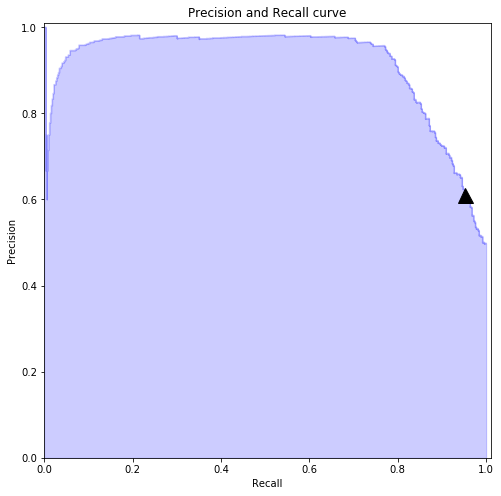

In [6]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

X_train, X_test = ml_train[X_cols_1], ml_val[X_cols_1]
y_train, y_test = np.where(ml_train[y_cols]=="Danger",1,0), np.where(ml_val[y_cols]=="Danger",1,0)
lr_pipe = Pipeline([('scaler', StandardScaler()),
                  ('lr', LogisticRegression(random_state=0,
                                           solver="sag"))])
lr_pipe.fit(X_train, y_train)
# get y_hat
y_hat = lr_pipe.predict_proba(X_test)[:, 1]

p, r, thresholds = tu.precision_recall_curve(y_test, y_hat)

target_r = 0.95
t_opt_lr = thresholds[np.argmin(np.abs(r-target_r))]
print("Threshold to achieve Sensitivity of {}: {}".format(target_r, t_opt_lr))

tu.precision_recall_threshold(p, r, thresholds, y_hat, y_test, t= t_opt_lr)

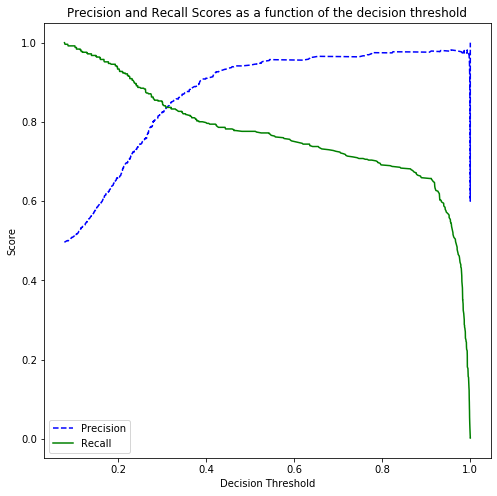

In [7]:
tu.plot_precision_recall_vs_threshold(p, r, thresholds)

Area under ROC curve: 0.9129337381040663


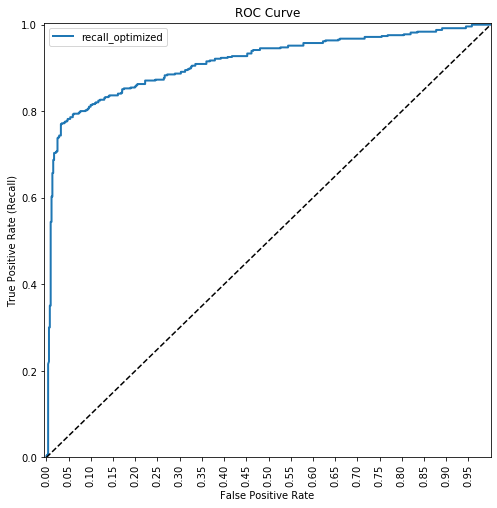

In [8]:
fpr, tpr, auc_thresholds = tu.roc_curve(y_test, y_hat)
print("Area under ROC curve: {}".format(auc(fpr, tpr))) # AUC of ROC
tu.plot_roc_curve(fpr, tpr, 'recall_optimized')
plt.savefig("lr_roc.pdf")
plt.savefig("lr_roc.png")
plt.show()

## Decision Tree Classifier
### Training

Search Complete in 5.37846302986145 seconds


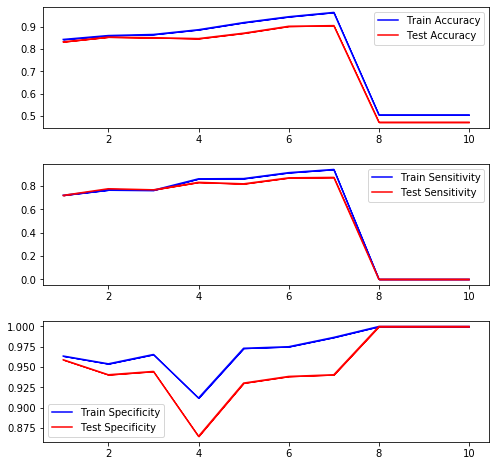

In [9]:
# load scikit learn logistic regression
from sklearn.tree import DecisionTreeClassifier

# parallel
from multiprocessing import Pool
from itertools import repeat

X = ml_train[X_cols]
y = np.where(ml_train[y_cols]=="Danger",1,0) # 1: Danger, 0 No_Danger

# perform bootstrapping to observe which coefficients can be dropped
b = 200
n_train = 0.5 # train on half, test on half
params = np.zeros((b,1+len(X_cols))) # storage for coefficeints
# storage for accuracy, sensitivity, specificity (for both train and test to check for overfitting)
nk = 10 # number of different depths to try
depths = np.arange(nk)+1 # zero depth tree doesnt make sense

scores = np.zeros((b, nk, 6))
bs = ShuffleSplit(n_splits = b,
                 random_state=0,
                 test_size=0.5)
iter = 0
start = time.time()
X_tr, X_te, y_tr, y_te = [], [], [], [] # storage lists
for train_index, test_index in bs.split(X):    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    X_tr.append(X_train)
    X_te.append(X_test)
    y_tr.append(y_train)
    y_te.append(y_test)
# evaluate performance in parallel
def return_scores(split, depths):
    train_index = split[0]
    test_index  = split[1]
    scores = np.zeros((nk,6))
    for i in range(nk):
        # fit the classifier
        dt_pipe = Pipeline([('scaler', StandardScaler()),
                 ('dt', DecisionTreeClassifier(random_state=0,
                        max_depth=depths[i]))])
        dt_pipe.fit(X_train, y_train)
        # threshold optimisation
        y_hat = dt_pipe.predict_proba(X_train)[:, 1]
        p, r, thresholds = tu.precision_recall_curve(y_train, y_hat)
        target_r = 0.95
        t_opt = thresholds[np.argmin(np.abs(r-target_r))]
        # score the model on train data first
        scores[i,:3] = score_model(dt_pipe, X_train, y_train, t=t_opt)
        # score the model on test data
        scores[i,3:] = score_model(dt_pipe, X_test, y_test, t=t_opt)
    return scores
with Pool(os.cpu_count()) as pool:
    res = pool.starmap(return_scores,
                        zip(bs.split(X),
                            repeat(depths)))
print("Search Complete in {} seconds".format(time.time()-start))
scores = np.array(res)

# get the confidence intervals
up = np.percentile(scores, 95, axis=0)
med = np.percentile(scores, 50, axis=0)
lo = np.percentile(scores, 5, axis=0)

# Plot 1: Accuracy with depth
metric = "Accuracy"
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(3, 1, 1)
ax.fill_between(depths, up[:,0], lo[:,0], color="b")
ax.plot(depths, med[:,0], c="b", label="Train {}".format(metric))
ax.fill_between(depths, up[:,3], lo[:,3], color="r")
ax.plot(depths, med[:,3], c="r", label="Test {}".format(metric))
ax.legend()


# Plot 2: Sensitivity with depth
metric = "Sensitivity"
ax = fig.add_subplot(3, 1, 2)
ax.fill_between(depths, up[:,1], lo[:,1], color="b")
ax.plot(depths, med[:,1], c="b", label="Train {}".format(metric))
ax.fill_between(depths, up[:,4], lo[:,4], color="r")
ax.plot(depths, med[:,4], c="r", label="Test {}".format(metric))
ax.legend()

# Plot 3: Specificity with depth
metric = "Specificity"
ax = fig.add_subplot(3, 1, 3)
ax.fill_between(depths, up[:,2], lo[:,2], color="b")
ax.plot(depths, med[:,2], c="b", label="Train {}".format(metric))
ax.fill_between(depths, up[:,5], lo[:,5], color="r")
ax.plot(depths, med[:,5], c="r", label="Test {}".format(metric))
ax.legend()


plt.subplots_adjust(hspace=0.3)
plt.savefig("dt.pdf")
plt.savefig("dt.png")
plt.show()


## Decision Tree
### Threshold Selection

Threshold to achieve Sensitivity of 0.95: 0.125
     pred_neg  pred_pos
neg       242       280
pos        31       465
Sensitivity (Recall): 0.9375
Specificity         : 0.46360153256704983


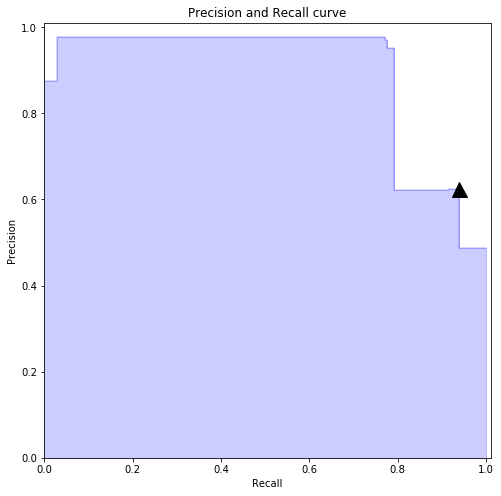

In [10]:
# optimal depth appears to be 3 as overfitting happens afterwards
max_depth=3
X_train, X_test = ml_train[X_cols], ml_val[X_cols]
y_train, y_test = np.where(ml_train[y_cols]=="Danger",1,0), np.where(ml_val[y_cols]=="Danger",1,0)
clf = DecisionTreeClassifier(random_state=0,
                        max_depth=max_depth).fit(X_train,y_train)
# get y_hat
y_hat = clf.predict_proba(X_test)[:, 1]

p, r, thresholds = tu.precision_recall_curve(y_test, y_hat)

target_r = 0.95
t_opt_dt = thresholds[np.argmin(np.abs(r-target_r))]
print("Threshold to achieve Sensitivity of {}: {}".format(target_r, t_opt_dt))

tu.precision_recall_threshold(p, r, thresholds, y_hat, y_test, t= t_opt_dt)

Area under ROC curve: 0.8956151124706463


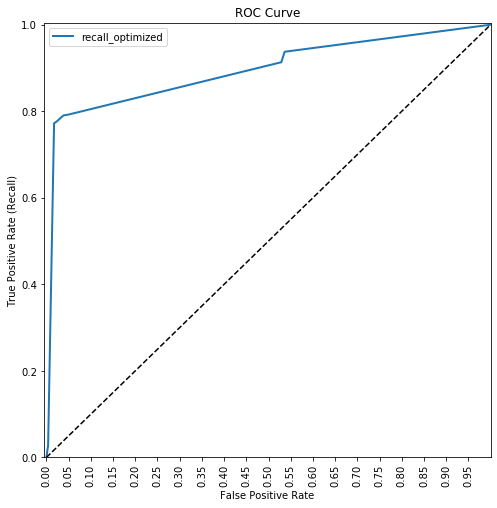

In [11]:
# roc curve
fpr, tpr, auc_thresholds = tu.roc_curve(y_test, y_hat)
print("Area under ROC curve: {}".format(auc(fpr, tpr))) # AUC of ROC
tu.plot_roc_curve(fpr, tpr, 'recall_optimized')
plt.savefig("dt_roc.pdf")
plt.savefig("dt_roc.png")
plt.show()

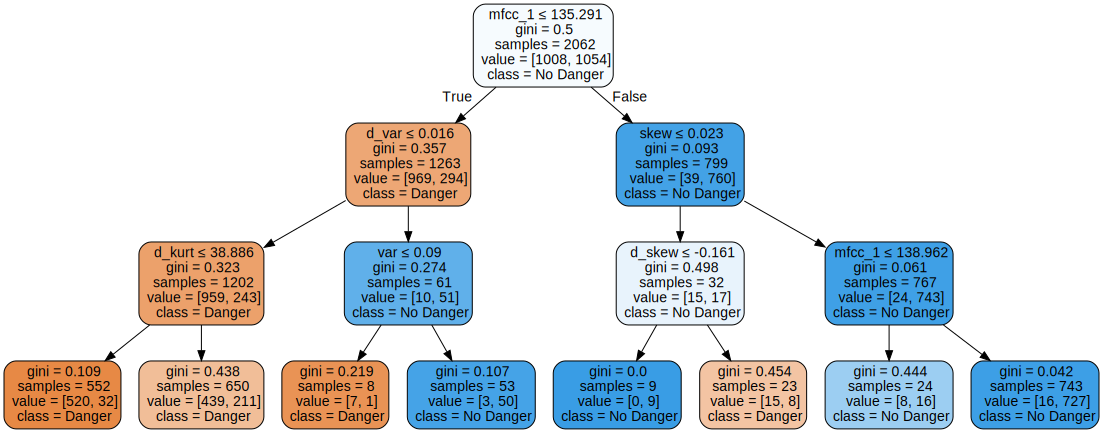

In [12]:
# plot the decision tree
# view the decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_cols,
                                class_names=["Danger", "No Danger"],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("dt_view")
graph

# Save Models in Pipeline
Save the models so that they can be easily reloaded

In [13]:
from joblib import dump, load

# config utilities
from common.data.labels.app.config_utils import JSONPropertiesFile

# logistic regression
# make sure we can automatically select the variables in X that LR expects
# don't want to be creating a dataframe every time this pipeline is called as that will get
# expensive quickly
# load in the model headers

# attempt to remove any previous config or pkl files
def cleanup(directory):
    while os.path.isfile(directory):
        # delete temporary file
        # file deletions appear to fail sometimes
        os.remove(directory)
        time.sleep(0.01)

m_loc = "common.model.training.n3060_dif.n3060_dif" # dataset configuration file
lr_model_store = os.path.join(git_root,"common/model/training/n3060_dif/n3060_dif_lr.pkl")

scaler_step_name = "scaler"
headers = m.const_header()
lr_sel_headers = [True if i in X_cols_0 else False for i in headers]

# write a config file
lr_CONFIG_FILE_LOC = "lr_config.json"

cleanup(lr_CONFIG_FILE_LOC)
cleanup(lr_model_store)

lr_default_properties = {
    'name'        : 'lr',
    'headers'     : headers,
    'sel_headers' : lr_sel_headers,
    'model_store' : lr_model_store,
    'm_loc'       : m_loc,
    'n_prev'      : 1,
    'scaler'      : scaler_step_name
}
config_file = JSONPropertiesFile(lr_CONFIG_FILE_LOC, lr_default_properties)
config = config_file.get()
config_file.set(config)
# dump the logistic regression model
X_train, X_test = ml_train[X_cols_0], ml_val[X_cols_0] # recall that these are the variables it uses
y_train, y_test = np.where(ml_train[y_cols]=="Danger",1,0), np.where(ml_val[y_cols]=="Danger",1,0)

lr_pipe = Pipeline([(scaler_step_name, StandardScaler()),
                  ('lr', LogisticRegression(random_state=0,
                                           solver="sag"))])
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_test, y_test)
dump(lr_pipe, lr_model_store)


# store decision tree model
dt_model_store = os.path.join(git_root, "common/model/training/n3060_dif/n3060_dif_dt.pkl")
headers = m.const_header()
dt_sel_headers = [True if i in X_cols else False for i in headers]

# write a config file
dt_CONFIG_FILE_LOC = "dt_config.json"

cleanup(dt_CONFIG_FILE_LOC)
cleanup(dt_model_store)

dt_default_properties = {
    'name'        : 'dt',
    'headers'     : headers,
    'sel_headers' : dt_sel_headers,
    'model_store' : dt_model_store,
    'm_loc'       : m_loc,
    'n_prev'      : 1,
    'scaler'      : scaler_step_name  
}
config_file = JSONPropertiesFile(dt_CONFIG_FILE_LOC, dt_default_properties)
config = config_file.get()
config_file.set(config)
# dump the decision tree classifier model
X_train, X_test = ml_train[X_cols], ml_val[X_cols] # recall that these are the variables it uses
y_train, y_test = np.where(ml_train[y_cols]=="Danger",1,0), np.where(ml_val[y_cols]=="Danger",1,0)

dt_pipe = Pipeline([(scaler_step_name, StandardScaler()),
                 ('dt', DecisionTreeClassifier(random_state=0,
                        max_depth=max_depth))])
dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)
dump(dt_pipe, dt_model_store)

['/home/matthew/Documents/GapWatch/common/model/training/n3060_dif/n3060_dif_dt.pkl']

# Compare Models
Simulated live inference.
Find a video in the test set with a Dangerous scene and observe how:

1. Predictors change
2. Model predictions change

## Compare Models:
### Previously seen footage
How do the models perform when used on a video that they have seen before?


In [14]:
# select a video
import common.model.training.general_demo as demo
# vid_url = ml_test.loc[(ml_test[headers[0]]=="Danger")&(ml_test[headers[2]] > 100), headers[1]].values[0]
vid_url = ml_train.loc[(ml_train[headers[0]]=="Danger")&(ml_train[headers[2]] > 100), headers[1]].values[0]
out_file = os.path.join(git_root,"common/model/training/n3060_dif/n3060_dif_inference.csv") # save the demo data here
# do the demo
print("Performing inference on video: \n{}".format(vid_url))
demo_df = demo.inference_demo(vid_url, out_file, [dt_CONFIG_FILE_LOC,
                                                 lr_CONFIG_FILE_LOC])

Using TensorFlow backend.


Performing inference on video: 
/home/matthew/Documents/GapWatch/common/data/labels/app/static/32.mp4
The camera was initialised: True
Models loaded


MODEL dt: 
 -*--*--*--*--*--*--*--*--*--*- 
Features: 
{'mean': True, 'd_mean': True, 'var': True, 'd_var': True, 'kurt': True, 'd_kurt': True, 'skew': True, 'd_skew': True, 'mfcc_0': True, 'mfcc_1': True, 'mfcc_2': True, 'mfcc_3': True, 'mfcc_4': True, 'mfcc_5': True, 'mfcc_6': True, 'mfcc_7': True, 'mfcc_8': True, 'mfcc_9': True, 'd_mfcc_0': True, 'd_mfcc_1': True, 'd_mfcc_2': True, 'd_mfcc_3': True, 'd_mfcc_4': True, 'd_mfcc_5': True, 'd_mfcc_6': True, 'd_mfcc_7': True, 'd_mfcc_8': True, 'd_mfcc_9': True}
Mean: 
[-2.48552980e-01  9.12789344e-04  1.11479047e-01  1.31448124e-02
  6.14099925e-01  2.83164501e+02  4.14261481e-01  6.16285385e-01
  5.91487429e+02  1.40709848e+02 -1.50895553e+01  2.36219541e+01
  4.30275928e+01 -3.29447931e+01  4.91280948e+01 -2.13580113e+01
  1.79698342e+01  1.35835437e+01  1.92933918e-01 -1.57717345e-01
 -3

100% (8968 of 8968) |####################| Elapsed Time: 0:03:43 Time:  0:03:43


Effective Frame Rate: 40.07336159289219
['dt' 'lr' 'mean' 'd_mean' 'var' 'd_var' 'kurt' 'd_kurt' 'skew' 'd_skew'
 'mfcc_0' 'mfcc_1' 'mfcc_2' 'mfcc_3' 'mfcc_4' 'mfcc_5' 'mfcc_6' 'mfcc_7'
 'mfcc_8' 'mfcc_9' 'd_mfcc_0' 'd_mfcc_1' 'd_mfcc_2' 'd_mfcc_3' 'd_mfcc_4'
 'd_mfcc_5' 'd_mfcc_6' 'd_mfcc_7' 'd_mfcc_8' 'd_mfcc_9']
Releasing Camera and Microphone


In [15]:
# Take a look
demo_df.describe()

,dt,lr,mean,d_mean,var,d_var,kurt,d_kurt,skew,d_skew,...,d_mfcc_0,d_mfcc_1,d_mfcc_2,d_mfcc_3,d_mfcc_4,d_mfcc_5,d_mfcc_6,d_mfcc_7,d_mfcc_8,d_mfcc_9
count,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,...,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000,8968.000000
mean,0.220520,0.201530,-0.257385,0.000002,0.074652,0.004763,0.597463,124.258982,0.223183,-0.060912,...,0.001886,0.000211,-0.001498,-0.000835,0.000671,-0.000175,0.001513,-0.000829,-0.000327,-0.000072
std,0.172339,0.117708,0.061718,0.001991,0.007205,0.005098,0.203214,619.270547,0.103628,3.508863,...,11.959000,8.078325,6.132899,5.131539,6.122649,7.448175,6.694182,6.305028,5.029099,5.151624
min,0.057971,0.027772,-0.493931,-0.060189,0.063860,0.000000,-0.255483,-3.000000,0.019903,-209.829529,...,-44.495300,-38.453506,-22.810446,-19.113640,-23.953522,-32.322456,-30.464008,-29.948742,-19.411484,-23.552898
25%,0.057971,0.125929,-0.305961,-0.000538,0.069495,0.000016,0.414296,27.363298,0.143205,-0.307050,...,-8.233398,-5.239401,-4.096860,-3.409234,-4.049686,-5.024692,-4.281115,-4.196385,-3.457722,-3.432716
50%,0.324615,0.179361,-0.274044,0.000006,0.072584,0.003696,0.610719,39.920490,0.236952,0.013045,...,-0.056976,-0.019711,-0.082334,-0.008874,0.027685,-0.031629,0.069061,-0.042224,0.009835,0.008413
75%,0.324615,0.243484,-0.206286,0.000495,0.080739,0.007145,0.717565,68.888861,0.293342,0.343987,...,8.169083,5.222349,4.095070,3.429281,4.107432,5.045892,4.373493,4.082019,3.386732,3.513546
max,0.978466,0.998652,-0.142944,0.123031,0.110752,0.055332,1.045778,45375.882812,0.855203,111.986595,...,44.089844,39.273720,22.357983,21.919437,23.214111,27.309828,24.644382,24.822552,19.241081,19.942705


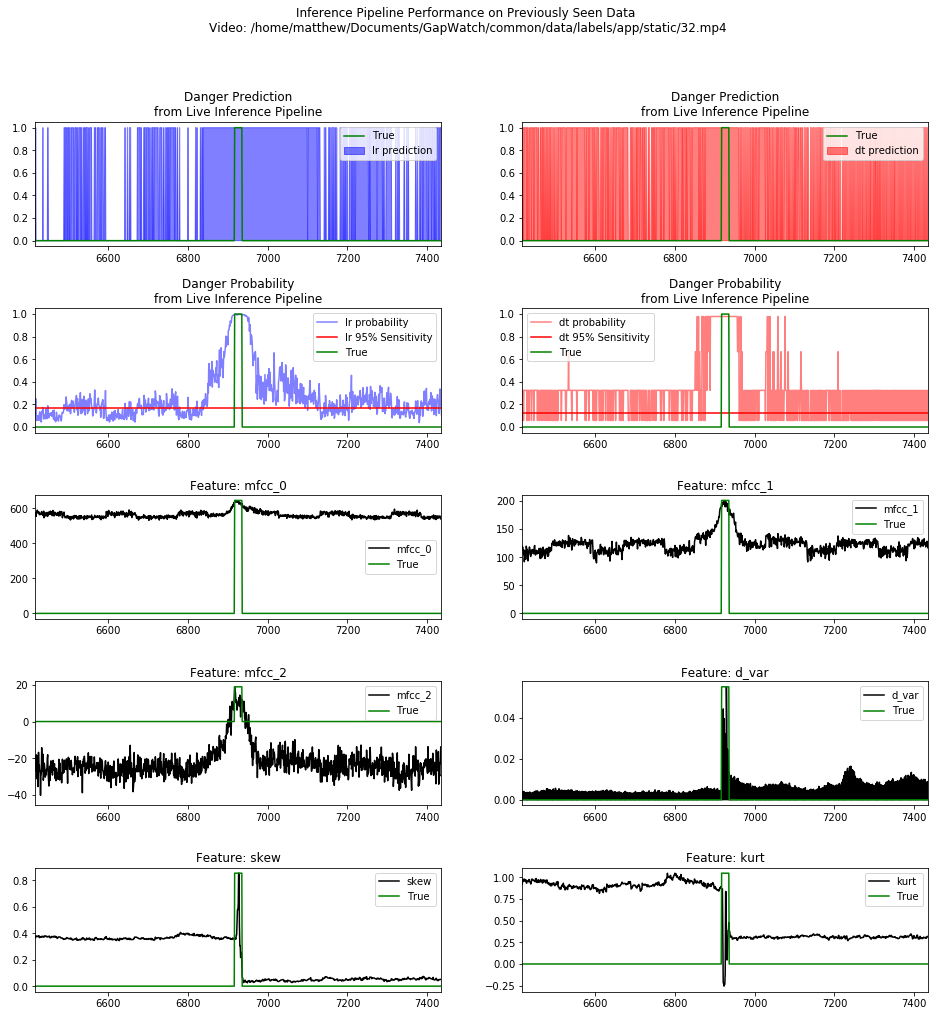

In [16]:
# find the first and last danger frames
# NOTE: this assumes that there is only one dangerous period in the clip
# a more advanced window function could be used to deal with this case better
# or using nearest labeled frame etc

danger_start = ml_train.loc[(ml_train[headers[1]]==vid_url)&(ml_train[headers[0]]=="Danger"),headers[2]].min()
danger_end   = ml_train.loc[(ml_train[headers[1]]==vid_url)&(ml_train[headers[0]]=="Danger"),headers[2]].max()

y_hat_lr_score = demo_df["lr"]
y_hat_dt_score = demo_df["dt"]

# get predicted scores
# convert the scores to predictions using threshold
y_hat_lr = np.where(y_hat_lr_score>t_opt_lr,1,0)
y_hat_dt = np.where(y_hat_dt_score>t_opt_dt,1,0)

frames = np.arange(len(y_hat_lr))
y_true = np.where((frames>=danger_start)&(frames<=danger_end),1,0)

# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(frames, y_true, color="g", label="True Label")
# ax.plot(frames, y_hat_dt, color="r", label="dt")
# ax.plot(frames, y_hat_lr, color="b", label="lr")
offset = 500
alpha = 0.5

frames = demo_df.index
fig = plt.figure(figsize = (16,16))
fig.suptitle('Inference Pipeline Performance on Previously Seen Data \nVideo: {}\n'.format(vid_url))
ax = fig.add_subplot(5, 2, 1)
ax.set_title("Danger Prediction\nfrom Live Inference Pipeline")
ax.fill_between(frames, y_hat_lr, np.repeat(0, frames.shape[0]), color="b", alpha = alpha, label="lr prediction")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 2)
ax.set_title("Danger Prediction\nfrom Live Inference Pipeline")
ax.fill_between(frames, y_hat_dt, np.repeat(0, frames.shape[0]),  color="r", alpha = alpha, label="dt prediction")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 3)
ax.set_title("Danger Probability\nfrom Live Inference Pipeline")
ax.plot(frames, y_hat_lr_score, color="b", alpha = alpha, label="lr probability")
ax.plot(frames, np.repeat(t_opt_lr, frames.shape[0]), color="r", label="lr 95% Sensitivity")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 4)
ax.set_title("Danger Probability\nfrom Live Inference Pipeline")
ax.plot(frames, y_hat_dt_score, color="r", alpha = alpha, label="dt probability")
ax.plot(frames, np.repeat(t_opt_dt, frames.shape[0]), color="r", label="dt 95% Sensitivity")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

# add plots of individual features that are most important
feat = "mfcc_0"
ax = fig.add_subplot(5, 2, 5)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "mfcc_1"
ax = fig.add_subplot(5, 2, 6)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "mfcc_2"
ax = fig.add_subplot(5, 2, 7)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "d_var"
ax = fig.add_subplot(5, 2, 8)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "skew"
ax = fig.add_subplot(5, 2, 9)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "kurt"
ax = fig.add_subplot(5, 2, 10)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()


plt.subplots_adjust(hspace=0.5)
plt.savefig("seen.pdf")
plt.savefig("seen.png")


## Compare Models:
### Previously Unseen Footage

In [17]:
# select a video
import common.model.training.general_demo as demo
# vid_url = ml_test.loc[(ml_test[headers[0]]=="Danger")&(ml_test[headers[2]] > 100), headers[1]].values[0]
vid_url = ml_test.loc[(ml_test[headers[0]]=="Danger")&(ml_test[headers[2]] > 100), headers[1]].values[0]
out_file = os.path.join(git_root,"common/model/training/n3060_dif/n3060_dif_inference.csv") # save the demo data here
# do the demo
print("Performing inference on video: \n{}".format(vid_url))
demo_df = demo.inference_demo(vid_url, out_file, [dt_CONFIG_FILE_LOC,
                                                 lr_CONFIG_FILE_LOC])

Performing inference on video: 
/home/matthew/Documents/GapWatch/common/data/labels/app/static/92.mp4
The camera was initialised: True


  0% (5 of 3895) |                       | Elapsed Time: 0:00:00 ETA:   0:01:27

Models loaded


MODEL dt: 
 -*--*--*--*--*--*--*--*--*--*- 
Features: 
{'mean': True, 'd_mean': True, 'var': True, 'd_var': True, 'kurt': True, 'd_kurt': True, 'skew': True, 'd_skew': True, 'mfcc_0': True, 'mfcc_1': True, 'mfcc_2': True, 'mfcc_3': True, 'mfcc_4': True, 'mfcc_5': True, 'mfcc_6': True, 'mfcc_7': True, 'mfcc_8': True, 'mfcc_9': True, 'd_mfcc_0': True, 'd_mfcc_1': True, 'd_mfcc_2': True, 'd_mfcc_3': True, 'd_mfcc_4': True, 'd_mfcc_5': True, 'd_mfcc_6': True, 'd_mfcc_7': True, 'd_mfcc_8': True, 'd_mfcc_9': True}
Mean: 
[-2.48552980e-01  9.12789344e-04  1.11479047e-01  1.31448124e-02
  6.14099925e-01  2.83164501e+02  4.14261481e-01  6.16285385e-01
  5.91487429e+02  1.40709848e+02 -1.50895553e+01  2.36219541e+01
  4.30275928e+01 -3.29447931e+01  4.91280948e+01 -2.13580113e+01
  1.79698342e+01  1.35835437e+01  1.92933918e-01 -1.57717345e-01
 -3.05723358e-01  9.45620322e-02  2.74223188e-01  1.08250598e-01
  1.01746429e-01 -2.10292599e-01 -2.10188133e-01  1.69203752e-01]
Varianc

100% (3895 of 3895) |####################| Elapsed Time: 0:01:32 Time:  0:01:32


Effective Frame Rate: 42.14768655005526
['dt' 'lr' 'mean' 'd_mean' 'var' 'd_var' 'kurt' 'd_kurt' 'skew' 'd_skew'
 'mfcc_0' 'mfcc_1' 'mfcc_2' 'mfcc_3' 'mfcc_4' 'mfcc_5' 'mfcc_6' 'mfcc_7'
 'mfcc_8' 'mfcc_9' 'd_mfcc_0' 'd_mfcc_1' 'd_mfcc_2' 'd_mfcc_3' 'd_mfcc_4'
 'd_mfcc_5' 'd_mfcc_6' 'd_mfcc_7' 'd_mfcc_8' 'd_mfcc_9']
Releasing Camera and Microphone


In [18]:
vid_url

'/home/matthew/Documents/GapWatch/common/data/labels/app/static/92.mp4'

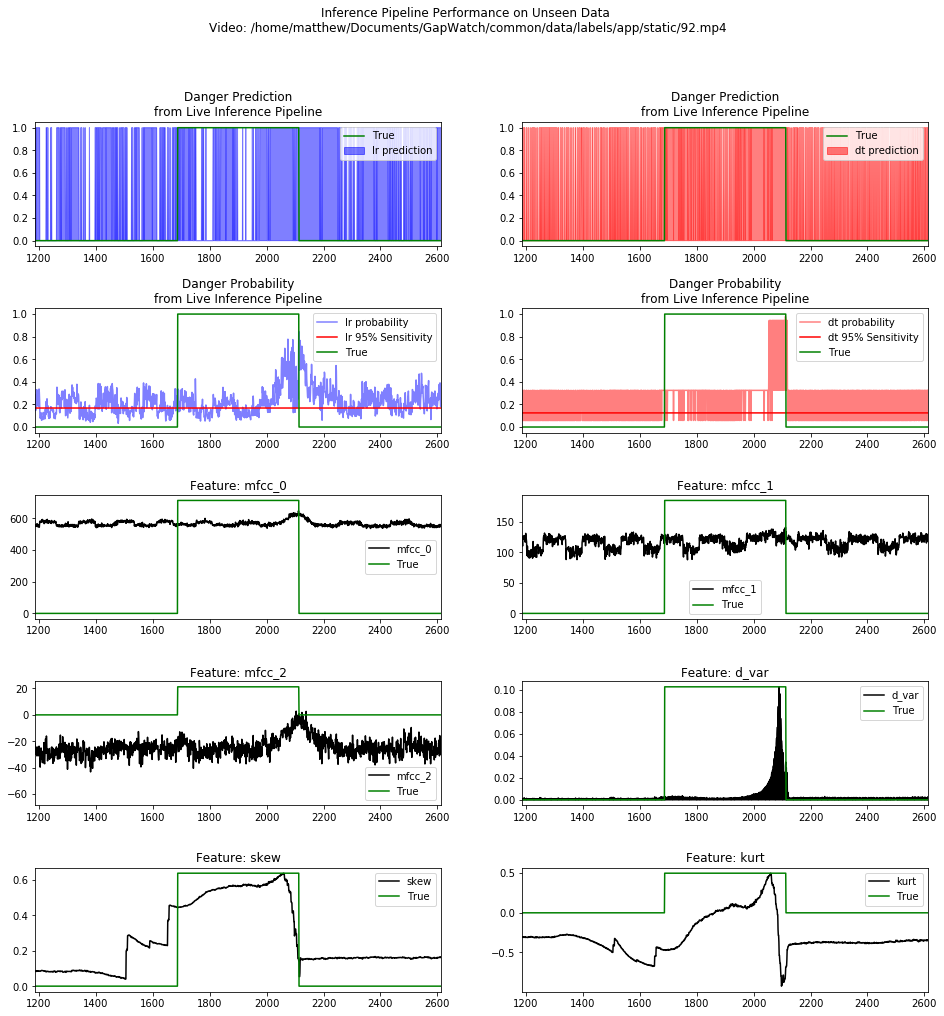

In [19]:
# find the first and last danger frames
# NOTE: this assumes that there is only one dangerous period in the clip
# a more advanced window function could be used to deal with this case better
# or using nearest labeled frame etc

danger_start = ml_test.loc[(ml_test[headers[1]]==vid_url)&(ml_test[headers[0]]=="Danger"),headers[2]].min()
danger_end   = ml_test.loc[(ml_test[headers[1]]==vid_url)&(ml_test[headers[0]]=="Danger"),headers[2]].max()

y_hat_lr_score = demo_df["lr"]
y_hat_dt_score = demo_df["dt"]
frames = np.arange(len(y_hat_lr_score))
y_true = np.where((frames>=danger_start)&(frames<=danger_end),1,0)

# get predicted scores
# convert the scores to predictions using threshold
y_hat_lr = np.where(y_hat_lr_score>t_opt_lr,1,0)
y_hat_dt = np.where(y_hat_dt_score>t_opt_dt,1,0)

# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(frames, y_true, color="g", label="True Label")
# ax.plot(frames, y_hat_dt, color="r", label="dt")
# ax.plot(frames, y_hat_lr, color="b", label="lr")
offset = 500
alpha = 0.5

frames = demo_df.index
fig = plt.figure(figsize = (16,16))
fig.suptitle('Inference Pipeline Performance on Unseen Data \nVideo: {}\n'.format(vid_url))
ax = fig.add_subplot(5, 2, 1)
ax.set_title("Danger Prediction\nfrom Live Inference Pipeline")
ax.fill_between(frames, y_hat_lr, np.repeat(0, frames.shape[0]), color="b", alpha = alpha, label="lr prediction")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 2)
ax.set_title("Danger Prediction\nfrom Live Inference Pipeline")
ax.fill_between(frames, y_hat_dt, np.repeat(0, frames.shape[0]),  color="r", alpha = alpha, label="dt prediction")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 3)
ax.set_title("Danger Probability\nfrom Live Inference Pipeline")
ax.plot(frames, y_hat_lr_score, color="b", alpha = alpha, label="lr probability")
ax.plot(frames, np.repeat(t_opt_lr, frames.shape[0]), color="r", label="lr 95% Sensitivity")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

ax = fig.add_subplot(5, 2, 4)
ax.set_title("Danger Probability\nfrom Live Inference Pipeline")
ax.plot(frames, y_hat_dt_score, color="r", alpha = alpha, label="dt probability")
ax.plot(frames, np.repeat(t_opt_dt, frames.shape[0]), color="r", label="dt 95% Sensitivity")
ax.plot(frames, y_true, color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

# add plots of individual features that are most important
feat = "mfcc_0"
ax = fig.add_subplot(5, 2, 5)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "mfcc_1"
ax = fig.add_subplot(5, 2, 6)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "mfcc_2"
ax = fig.add_subplot(5, 2, 7)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "d_var"
ax = fig.add_subplot(5, 2, 8)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "skew"
ax = fig.add_subplot(5, 2, 9)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()

feat = "kurt"
ax = fig.add_subplot(5, 2, 10)
ax.set_title("Feature: {}".format(feat))
ax.plot(frames, demo_df[feat], color="k", label=feat)
ax.plot(frames, y_true*demo_df[feat].max(), color = "g", label="True")
ax.set_xlim((max(0,danger_start-offset),danger_end+offset))
ax.legend()


plt.subplots_adjust(hspace=0.5)
plt.savefig("unseen.pdf")
plt.savefig("unseen.png")

# Debugging
It is important that the live inference platform produces the same results as the training data when shown the same video. Comparing the data produced by the "live" pipeline against the training data generated from the same video is a great way to compare the pipeline and sanity check that there are no bugs / differences in the live model and the one trained here.

In [20]:
# compare frames generated to frames in the dataset
current_df = ml_df.loc[ml_df[headers[1]]==vid_url,:]
frame_idx = current_df[headers[2]].values
current_df = current_df.set_index("frame")
check_df = demo_df.loc[(demo_df.index.isin(frame_idx)),X_cols]

# subtract to find the difference in the two
diff = current_df[X_cols].values - check_df.values

diff.mean(axis=0)

array([ 4.91093793e-10,  1.18603576e-12, -2.67736901e-10,  5.73804589e-13,
        5.26357723e-10, -3.19081902e-06,  1.29267212e-09, -2.28810617e-08,
       -3.97600442e-07,  1.67834224e-07, -8.94257155e-08, -2.83340142e-08,
        1.22490085e-07,  2.03038120e-08, -1.31250496e-08,  7.07604545e-09,
       -4.73277812e-08,  3.70742797e-08,  3.84786353e-08,  2.06476404e-08,
       -3.83703887e-09,  1.15647919e-08,  7.67453565e-09,  7.51858472e-09,
       -1.45378268e-08, -3.38260946e-08,  6.94555171e-09,  9.69915648e-09])

In [21]:
current_df.describe()

,mean,d_mean,var,d_var,kurt,d_kurt,skew,d_skew,mfcc_0,mfcc_1,...,d_mfcc_0,d_mfcc_1,d_mfcc_2,d_mfcc_3,d_mfcc_4,d_mfcc_5,d_mfcc_6,d_mfcc_7,d_mfcc_8,d_mfcc_9
count,98.000000,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,-0.213523,0.000308,0.108237,4.491073e-03,-0.139569,289.906089,0.383537,0.327427,570.106823,117.913401,...,1.047378,0.591735,0.591517,-0.013216,-0.577535,-0.038355,0.063797,0.175584,0.176969,0.471069
std,0.100298,0.005400,0.020875,1.259473e-02,0.271010,1462.826279,0.203915,11.543920,18.346506,10.575530,...,11.166055,7.666735,6.158972,5.485534,5.858962,7.912549,7.114081,6.768136,5.120634,5.168598
min,-0.360973,-0.017044,0.078949,1.571833e-08,-0.909892,0.975178,0.041062,-50.173866,538.409400,92.471090,...,-20.139221,-27.265388,-15.050837,-11.587301,-14.132828,-16.677984,-19.033787,-10.769167,-14.200561,-14.676182
25%,-0.302529,-0.000880,0.098204,1.235677e-05,-0.341056,22.262772,0.172751,-0.532823,556.774325,109.140887,...,-6.549103,-4.421545,-3.425441,-3.496124,-4.677628,-6.014137,-5.681630,-4.926431,-2.603488,-3.035887
50%,-0.233009,-0.000009,0.101892,1.235715e-03,-0.102185,68.503185,0.478855,-0.027536,565.996800,121.657120,...,-0.229889,-0.695160,-0.190017,-0.365570,-0.257067,-0.003735,0.681396,-0.836210,-0.217082,0.969608
75%,-0.117098,0.000443,0.112215,2.265016e-03,0.065400,124.797019,0.564388,0.471029,578.457322,125.650525,...,7.821091,5.967987,4.028104,3.905458,3.091475,4.310399,4.283040,4.845200,3.405110,4.443839
max,-0.005009,0.038811,0.213265,9.654108e-02,0.470840,13678.991000,0.629275,100.945890,628.211600,139.697560,...,52.719240,18.936470,19.260140,14.707638,14.208977,22.510384,17.832794,24.934875,15.737540,10.469734


In [22]:
check_df.describe()

,mean,d_mean,var,d_var,kurt,d_kurt,skew,d_skew,mfcc_0,mfcc_1,...,d_mfcc_0,d_mfcc_1,d_mfcc_2,d_mfcc_3,d_mfcc_4,d_mfcc_5,d_mfcc_6,d_mfcc_7,d_mfcc_8,d_mfcc_9
count,98.000000,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,-0.213523,0.000308,0.108237,4.491073e-03,-0.139569,289.906092,0.383537,0.327427,570.106823,117.913401,...,1.047378,0.591735,0.591517,-0.013216,-0.577535,-0.038355,0.063797,0.175584,0.176969,0.471069
std,0.100298,0.005400,0.020875,1.259473e-02,0.271010,1462.826302,0.203915,11.543920,18.346506,10.575530,...,11.166055,7.666736,6.158972,5.485534,5.858962,7.912549,7.114081,6.768136,5.120634,5.168598
min,-0.360973,-0.017044,0.078949,1.571833e-08,-0.909892,0.975178,0.041062,-50.173866,538.409424,92.471092,...,-20.139221,-27.265388,-15.050837,-11.587301,-14.132828,-16.677984,-19.033787,-10.769167,-14.200561,-14.676182
25%,-0.302529,-0.000880,0.098204,1.235677e-05,-0.341056,22.262772,0.172751,-0.532823,556.774323,109.140886,...,-6.549103,-4.421545,-3.425442,-3.496124,-4.677628,-6.014137,-5.681630,-4.926431,-2.603488,-3.035887
50%,-0.233009,-0.000009,0.101892,1.235715e-03,-0.102185,68.503185,0.478855,-0.027536,565.996826,121.657120,...,-0.229889,-0.695160,-0.190017,-0.365570,-0.257067,-0.003735,0.681396,-0.836210,-0.217082,0.969608
75%,-0.117098,0.000443,0.112215,2.265016e-03,0.065400,124.797018,0.564388,0.471029,578.457321,125.650522,...,7.821091,5.967987,4.028104,3.905458,3.091475,4.310399,4.283040,4.845200,3.405110,4.443839
max,-0.005009,0.038811,0.213265,9.654108e-02,0.470840,13678.991211,0.629275,100.945892,628.211609,139.697556,...,52.719238,18.936470,19.260139,14.707638,14.208977,22.510384,17.832794,24.934875,15.737540,10.469734
